# Week 5 Problem 3

If you are not using the `Assignments` tab on the course JupyterHub server to read this notebook, read [Activating the assignments tab](https://github.com/lcdm-uiuc/info490-sp17/blob/master/help/act_assign_tab.md).

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do **not** write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select _Kernel_, and restart the kernel and run all cells (_Restart & Run all_).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select _File_  → _Save and CheckPoint_)

5. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

# Problem 5.3. Density Estimation.

In this problem, we will first plot rug plots and histograms of travel time in the flights data. We then use Seaborn, Scipy, and Scikit-learn to calculate and plot Kernel Density Estimation (KDE).

In [141]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
from scipy import stats, integrate
from sklearn.neighbors import KernelDensity

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal

We use the `AirTime` column at the Willard airport.

In [142]:
df = pd.read_csv(
    '/home/data_scientist/data/2001.csv',
    encoding='latin-1',
    usecols=(13, 16)
    )

In [143]:
local = df[df['Origin'] == 'CMI']
local = local.drop(['Origin'], axis=1) # we don't need the Origin column anymore.
local.dropna(inplace=True)

## Rug plots

- Plot rug plots. See lesson the notebook, docstring, test cases, and sample plots for details.

![](./images/rug_no_jitter.png)

![](./images/rug_jittered.png)

In [144]:
def plot_rugplot(df, column='AirTime', jitter=0.0, seed=0):
    '''
    Plots a rug plot.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    jitter: An int or float. Default: 0.
            If jitter > 0, uses numpy.random.normal() to draw
            random samples from a normal distribution with zero mean
            and standard deviatation equal to "jitter".
    seed: An int. Used by numpy.random.seed().
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    
    # YOUR CODE HERE
    
    # If jitter > 0, uses numpy.random.normal() to draw
    #        random samples from a normal distribution with zero mean
    #        and standard deviatation equal to "jitter".
    data = df[column]
    if jitter > 0:
        np.random.seed(seed)
        data = data + np.random.normal(0, jitter, len(df[column]))
    
    # initialize, setup seaborn
    fig, ax = plt.subplots()
    sns.set_style('white')
    sns.rugplot(ax=ax, a=data, height=0.5, color='r')
    sns.despine(ax=ax, left=True, offset=2, trim=True)
    
    # take out ticks for y axis,
    ax.set_yticks([])
    ax.set_xlabel('AirTime')

    return ax

A rug plot with no jitter.

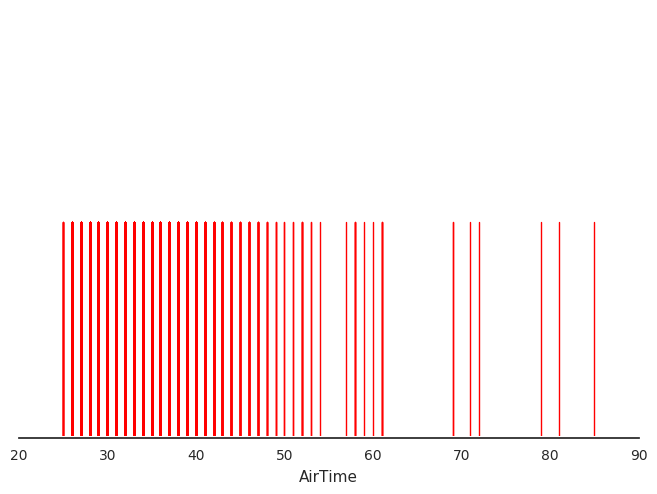

In [145]:
rug_no_jitter = plot_rugplot(df=local, jitter=0, seed=0)

In [146]:
assert_is_instance(rug_no_jitter, mpl.axes.Axes)
assert_equal(len(rug_no_jitter.lines), len(local))

for i in range(len(local)):
    xdata, ydata = rug_no_jitter.lines[i].get_xydata().T
    assert_array_equal(xdata, local.iloc[i, 0])
    assert_equal(ydata[1] - ydata[0] > 0, True)
    
assert_is_not(rug_no_jitter.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")

A rug plot with random jitter. Adding jitter improves visualization.

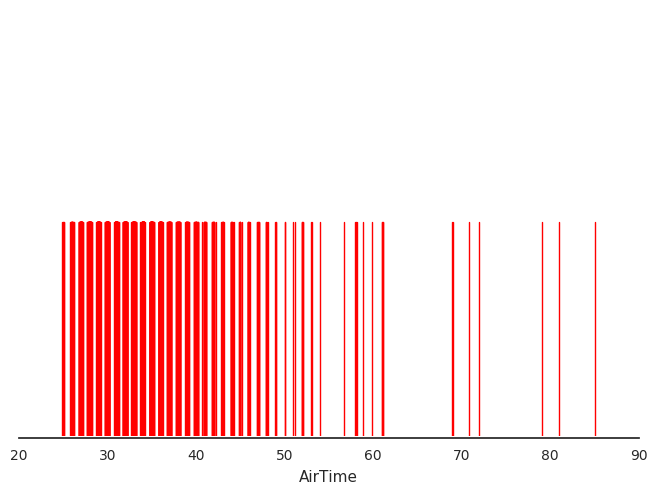

In [147]:
rug_jittered = plot_rugplot(df=local, jitter=0.1, seed=0)

In [148]:
assert_equal(len(rug_jittered.lines), len(local))

np.random.seed(0)
for i in range(len(local)):
    xdata, ydata = rug_jittered.lines[i].get_xydata().T
    assert_equal(xdata[0], xdata[1])
    assert_almost_equal(xdata[0], local.iloc[i, 0] + np.random.normal(0, 0.1)) # jitter is 0.1
    assert_equal(ydata[1] - ydata[0] > 0, True)
    
assert_is_not(rug_jittered.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")

## Histograms

- Plot histograms. See the lesson notebook, docstring, test cases, and sample plots for details.

![](./images/hist_10_bins.png)

![](./images/hist_50_bins.png)

In [149]:
def plot_histogram(df, bins, column='AirTime', normed=False):
    '''
    Plots a histogram.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    normed: If true, the integral of the histogram will sum to 1
            (i.e. normalized) to form a probability density.
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    
    # YOUR CODE HERE
    
    # initialize
    fig, ax = plt.subplots()
    sns.set_style('white')
    sns.despine()
    
    # plot histogram
    ax.hist(df[column], bins=bins, alpha=0.5, color=sns.xkcd_rgb["denim blue"], normed=normed)
    
    # set graph attributes
    ax.set_xlabel('AirTime', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title('Histogram with ' + str(bins) + ' bins', fontsize=14)

    return ax

A histogram with 10 bins.

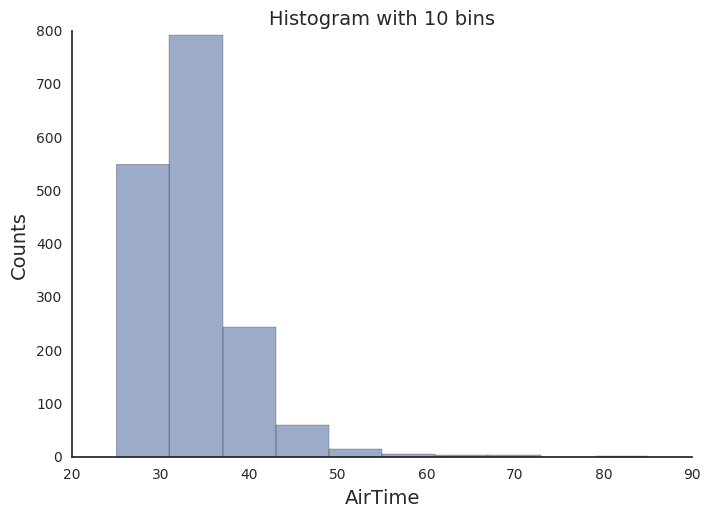

In [150]:
hist_10_bins = plot_histogram(df=local, bins=10)

In [151]:
assert_is_instance(hist_10_bins, mpl.axes.Axes)
patches = hist_10_bins.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
counts_a = [550, 792, 245,  61,  15,   7,   4,   4,   0,   3]
                    
for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_equal(patches[i].get_height(), counts_a[i])

# check label texts
assert_is_not(len(hist_10_bins.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(hist_10_bins.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(hist_10_bins.yaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")

A histogram with 50 bins. We see that changing the number of bins can have a significant effect on the shape of a histogram. As we will see shortly, KDE is less affected by the choice of bins and thus a better alternative.

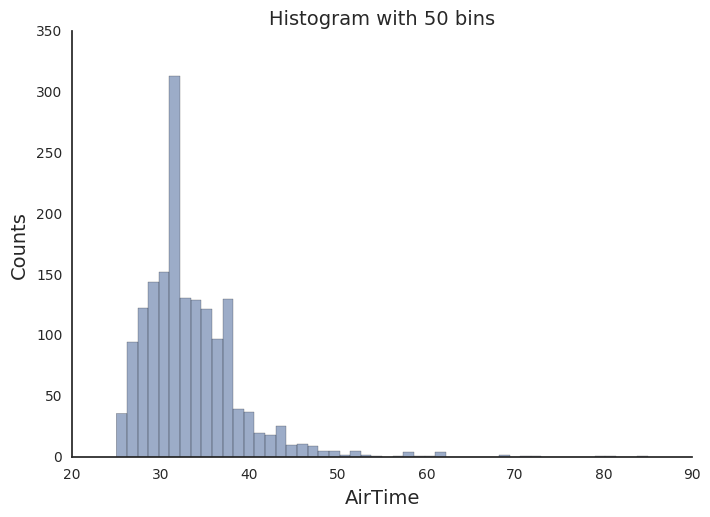

In [152]:
hist_50_bins = plot_histogram(df=local, bins=50)

In [153]:
assert_is_instance(hist_50_bins, mpl.axes.Axes)
patches = hist_50_bins.patches
assert_equal(len(patches), 50)

## distplot

- Use [seaborn.distplot](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.distplot.html) to plot a histogram, a KDE, and a rug plot, all in the same figure. See lesson notebook, docstring, test cases, and sample plot for details.

![](./images/dist_10_bins.png)

![](./images/dist_50_bins.png)

In [154]:
def plot_distplot(df, bins, column='AirTime'):
    '''
    Plots a "distplot".
    
    Parameters
    ----------
    df: A pandas.DataFrame
    bins: The number of bins
    column: The column to use in "df"
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    
    # YOUR CODE HERE
    
    ax = sns.distplot(df[column], kde=True, rug=True, bins=bins)
    ax.set_xlim(20,90)
    if (bins == 50):
        ax.set_ylim(0.00, 0.16)
    if (bins == 10):
        ax.set_ylim(0.00, 0.09)
    ax.set_xlabel('Air time (minutes)', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title('Distplot with '+str(bins)+' bins', fontsize=14)
    sns.despine(offset=5, trim=True)

    
    return ax

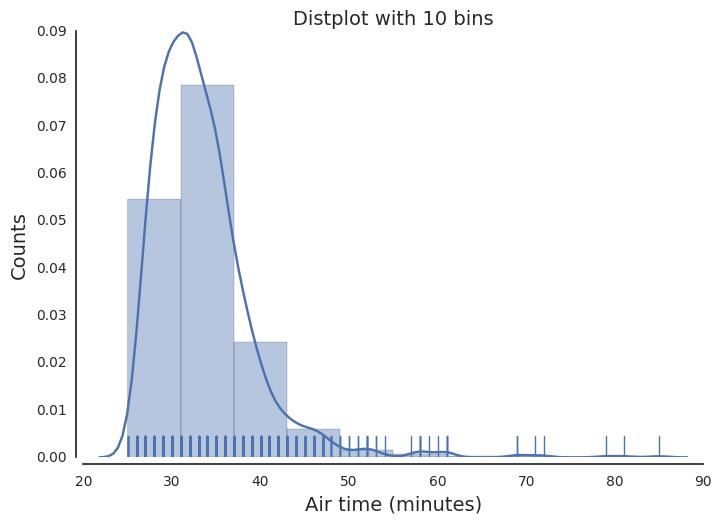

In [155]:
dist_10_bins = plot_distplot(df=local, bins=10)

In [156]:
assert_is_instance(dist_10_bins, mpl.axes.Axes)

# test histogram
patches = dist_10_bins.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde + rug plots
lines = dist_10_bins.lines
assert_equal(len(dist_10_bins.lines), len(local) + 1) # 1 kde + rug plots

# test kde
kdex, kdey = dist_10_bins.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# test rug plots
for i in range(len(local)):
    rugx, rugy = dist_10_bins.lines[i + 1].get_xydata().T
    assert_array_equal(rugx, local.iloc[i, 0])
    assert_equal(rugy[1] - rugy[0] > 0, True)
    
# check label texts
assert_is_not(len(dist_10_bins.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(dist_10_bins.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

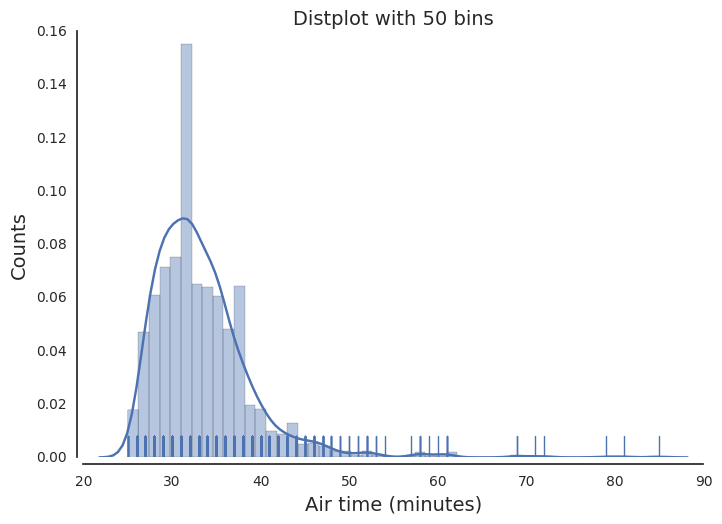

In [157]:
dist_50_bins = plot_distplot(df=local, bins=50)

In [158]:
assert_is_instance(dist_50_bins, mpl.axes.Axes)
# test histogram
patches = dist_50_bins.patches
assert_equal(len(patches), 50)

## Silverman's rule of thumb

- Write a function named `get_silverman_bandwidth()` that calculates the optimal KDE bandwidth using Silverman's rule of thumb. The formula for the optimal choice of bandwidth $h$ is given by

$h = \left( \frac{4{\hat\sigma}^5}{3n} \right)^{\frac{1}{5}} \approx 1.06 \hat\sigma n^{-1/5}$

where $\hat\sigma$ is the standard deviation of the samples and `n` is the number of samples. Source: [Wikipedia](https://en.wikipedia.org/wiki/Kernel_density_estimation#Practical_estimation_of_the_bandwidth)

In [159]:
def get_silverman_bandwidth(df, column='AirTime'):
    '''
    Calculates bandwidth for KDE using Silverman's rule of thumb.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    
    Returns
    -------
    A float
    '''
    
    # YOUR CODE HERE
    
    # get stdev of data, calculate silverman bandwidth
    stdev = np.std(df[column])
    bw = 1.06 * stdev * len(df[column]) ** (-0.2)
    
    return bw

In [160]:
rs = np.random.RandomState(0)
bw_t = pd.DataFrame({'AirTime': rs.randn(100)})
assert_almost_equal(get_silverman_bandwidth(bw_t), 0.425, 3)

rs = np.random.RandomState(0)
bw_t = pd.DataFrame({'AirTime': rs.randn(200)})
assert_almost_equal(get_silverman_bandwidth(bw_t), 0.375, 3)

## Gaussian Kernels

- Use `get_silverman_bandwidth()` and [stats.norm().pdf()](http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.norm.html) to generate Guassian kernels. See lesson notebook, docstring, and test cases for details.

In [161]:
def get_kernels(df, support, column='AirTime'):
    '''
    Generates Gaussian kernels.
    
    Parameters
    ----------
    df: A pandas.DataFrame.
    support: Input data points for the probability density function.
    column: The column that will be used in "df"
    
    Returns
    -------
    A 2-d numpy array
    '''
    
    # YOUR CODE HERE
    
    # get silverman bandwidth and data
    bw = get_silverman_bandwidth(df, column)
    data = df[column]
    
    # initialize kernels list
    kernels = []
    
    # for each entry in data, normalize and get distribution, add to kernels list
    for d in data:
        kernel = stats.norm(d, bw).pdf(support)
        kernels.append(kernel)
    
    return kernels

In [162]:
support_t = np.linspace(0, 1, 5)
rs = np.random.RandomState(0)
df_t = pd.DataFrame({'AirTime': rs.rand(2)})
kernels_t = get_kernels(df=df_t, support=support_t)
kernels_a = np.array(
    [[4.13769545e-11, 2.66353480e-03, 4.24566728e+00, 1.67579644e-01, 1.63788836e-07],
     [7.36686859e-19, 5.51357055e-08, 1.02181124e-01, 4.68917176e+00, 5.32855352e-03]]
    )
assert_array_almost_equal(kernels_t, kernels_a)

## Kernel density estimate

- Sum up the Gaussian kernels from `get_kernels()` and normalize by the total area. See lesson notebook, docstring, and test cases for details.

In [163]:
def normalize_kernels(support, kernels):
    '''
    Sums up the individual kernels and normalizes by total area.

    Parameters
    ----------
    support: A 1-d numpy array.
             Input data points for the probability density function.
    kernels: A 2-d numpy array.
             Kernels generated from "get_kernels()"
             
    Returns
    -------
    A 1-d numpy array
    '''
    
    # YOUR CODE HERE
    
    # To compute kernel density estimate, we sum up the individual kernels and 
    # normalize by total area.
    density = np.sum(kernels, axis=0)
    density /= integrate.trapz(density, support)
    
    return density

In [164]:
# We use the same kernels_t and support_t from the previous test for get_kernels
density_t = normalize_kernels(support=support_t, kernels=kernels_t)
density_a = np.array(
    [1.797059e-11, 1.156834e-03, 1.888331e+00, 2.109355e+00, 2.314336e-03]
    )
assert_array_almost_equal(density_t, density_a)

## Plot KDE (scipy version)

- Use `get_kernels()` and `normalize_kernels()` to plot a KDE and a histogram in the same figure.

![](./images/kde_scipy.png)

In [170]:
def plot_scipy_kde(df, support, column='AirTime', bins=50):
    '''
    Plots a KDE (using scipy functions) over a histogram.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    support: A 1-d numpy array.
             Input data points for the probability density function.
    
    Returns
    -------
    A matplotlib.axes.Axes instance.
    '''
    
    # YOUR CODE HERE
    
    # get kernels, density
    kernels = get_kernels(df, support)
    density = normalize_kernels(support, kernels)
    
    # initialize graph and sns
    fig,ax = plt.subplots()
    sns.set_style('white')
    sns.despine()
    
    # plot histogram and line
    ax.hist(df[column], bins=bins, alpha=0.5, color=sns.xkcd_rgb["denim blue"], normed=True)
    ax.plot(support, density)
    
    # set graph attributes
    ax.set(title='Kernel Density Plot (scipy)',
          xlabel='AirTime',
           ylabel='Counts',
    )
    return ax

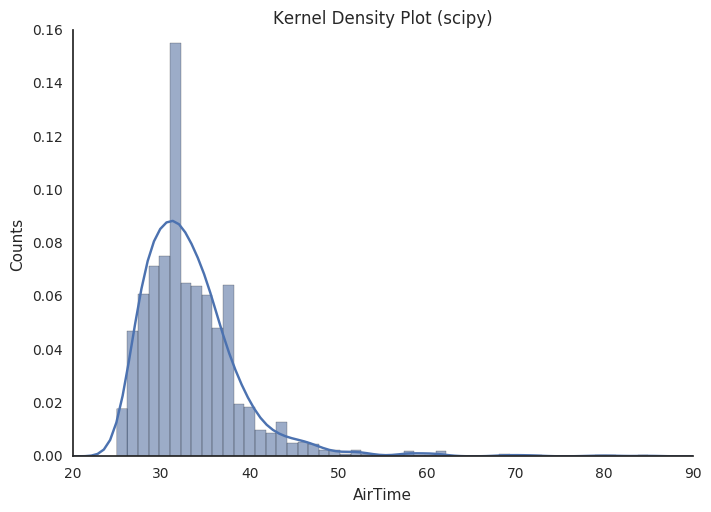

In [171]:
support = np.linspace(20, 90, 100)
kde_scipy = plot_scipy_kde(df=local, support=support)

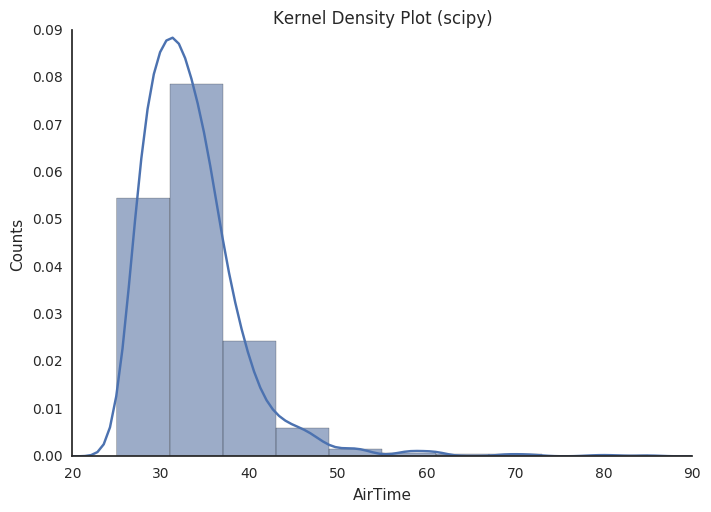

In [172]:
kde_scipy_t = plot_scipy_kde(df=local, support=support, bins=10)
assert_is_instance(kde_scipy_t, mpl.axes.Axes)

# test histogram
patches = kde_scipy_t.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde
lines = kde_scipy_t.lines
assert_equal(len(kde_scipy_t.lines), 1)
kdex, kdey = kde_scipy_t.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# check label texts
assert_is_not(len(kde_scipy_t.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(kde_scipy_t.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

## Plot KDE (sklearn version)

- Plot a KDE using the bandwidth calculated with Silverman's rule of thumb and [sklearn.neighbors.KernelDensity](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html). See lesson notebook, docstring, samplot plot, and test cases for details.

![](./images/kde_sklearn.png)

In [177]:
def plot_sklearn_kde(df, support, column='AirTime', bins=50):
    '''
    Plots a KDE and a histogram using sklearn.KernelDensity.
    Uses Gaussian kernels.
    The optimal bandwidth is calculated according to Silverman's rule of thumb.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    support: A 1-d numpy array.
             Input data points for the probability density function.
    
    Returns
    -------
    ax: A matplotlib.axes.Axes instance.
    kde: A sklearn.neighbors.kde.KernelDensity instance.
    '''
    
    # YOUR CODE HERE
    
    bw = get_silverman_bandwidth(df, column)
    # Gaussian KDE with Seaborn bandwidth
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)

    # Grab the data, and compute the support (sampling points)
    x = df[column]

    # Create the KDE, and return the support values.
    kde.fit(x[:, np.newaxis])
    y = kde.score_samples(support[:, np.newaxis])

    # Plot the results including underlying histogram
    # Initialize plots and do stuff, just like the notebook
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(x, bins=bins, alpha=0.5, color=sns.xkcd_rgb["denim blue"], normed=True)
    ax.plot(support, np.exp(y))
    # Set graph attributes
    plt.xlabel('AirTime', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.title('Kernel Density Plot (sklearn)', fontsize=14)

    sns.despine(offset=5, trim=True)
    plt.show()
    
    return ax, kde

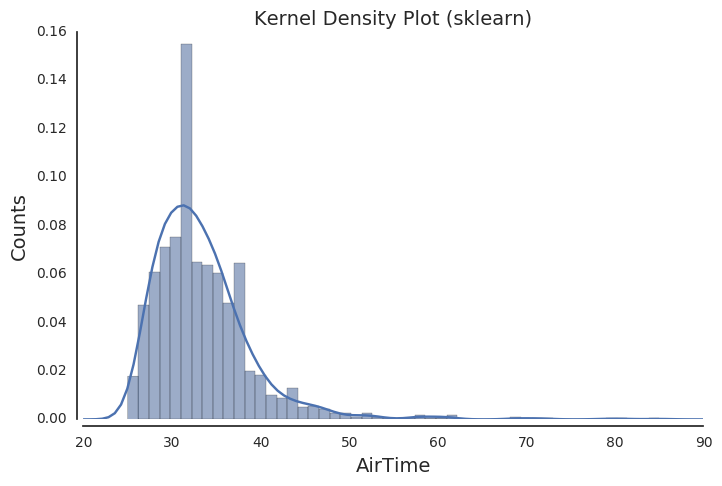

In [178]:
ax_kde_sklearn, kde_sklearn = plot_sklearn_kde(df=local, support=support)

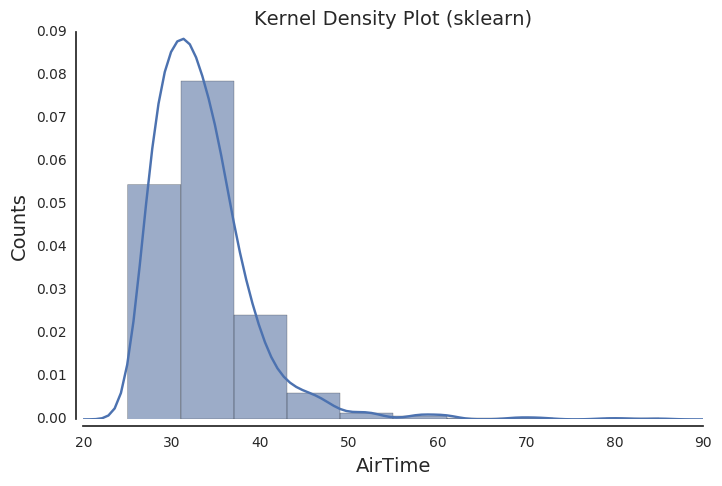

In [179]:
ax_kde_sklearn_t, kde_sklearn_t = plot_sklearn_kde(df=local, support=support, bins=10)
assert_is_instance(ax_kde_sklearn_t, mpl.axes.Axes)
assert_is_instance(kde_sklearn_t, KernelDensity)

# test histogram
patches = ax_kde_sklearn_t.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde
lines = ax_kde_sklearn_t.lines
assert_equal(len(ax_kde_sklearn_t.lines), 1)
kdex, kdey = ax_kde_sklearn_t.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# check label texts
assert_is_not(len(ax_kde_sklearn_t.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(ax_kde_sklearn_t.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")